In [1]:
from fmri.acquisitions import SparklingAcquisition
from fmri.reconstructors.base import SequentialFMRIReconstructor
from mri.operators import WaveletN 
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
from fmri.utils import ssos

In [2]:
data_file = "/volatile/pierre-antoine/optimed/meas_MID36_2D_Sparkling_1mmiso0_3s_FID3362.dat"
bin_file = "/volatile/pierre-antoine/optimed/dim2_i_RadialIO_P0.75_N192x192_FOV0.192x0.192_Nc6_Ns2688_c30_d2__D7M9Y2021T160.bin"
shifts = np.array((-22,30.82343864))


In [10]:
acq = SparklingAcquisition(data_file,bin_file,frame_slicer=slice(0,2),shifts=shifts)

pymapVBVD version 0.4.3
Software version: VB


Scan 1/1, read all mdhs:   0%|          | 0.00/15.4G [00:00<?, ?B/s]

.dat file red


read data:   0%|          | 0/12 [00:00<?, ?it/s]

kspace_data shape (13440, 32, 6, 2)
kspace_data shape (13440, 6, 32, 2)
kspace_data shape (6, 13440, 32, 2)
kspace_data shape (2, 32, 80640)
shifts [22.         30.82343864]
kspace_data imported
[192 192] (32, 161280) (161280, 2) (2,)


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   2 out of  32 | elapsed:    4.3s remaining:  1.1min
[Parallel(n_jobs=32)]: Done  32 out of  32 | elapsed:    4.7s finished


In [11]:
acq.kspace_data.shape, acq.kspace_loc.shape,

((2, 32, 80640), (80640, 2))

In [5]:
fourier_op = acq.get_fourier_operator(implementation='gpuNUFFT')
fourier_op.shape, fourier_op.samples, fourier_op.n_coils
mu=1e-8
regularizer_op = SparseThreshold(Identity(), mu, thresh_type="soft")

linear_op = WaveletN(wavelet_name='sym8',
                    nb_scale=3,
                    dim=2,)


/home/pc266769/.pyenv/versions/3.6.13/envs/fmri/lib/python3.6/site-packages/mri/operators/fourier/non_cartesian.py:448: UserWarning: Samples will be normalized between [-0.5; 0.5[
  warnings.warn("Samples will be normalized between [-0.5; 0.5[")
/home/pc266769/.pyenv/versions/3.6.13/envs/fmri/lib/python3.6/site-packages/mri/operators/fourier/utils.py:106: UserWarning: Frequency equal to 0.5 will be put in -0.5
  warnings.warn("Frequency equal to 0.5 will be put in -0.5")


In [6]:
rec = SequentialFMRIReconstructor(fourier_op, linear_op, regularizer_op, Smaps=acq.smaps, verbose=50, optimizer='pogm')

/volatile/pierre-antoine/gits/nsp/pysap-fmri/fmri/reconstructors/base.py:36: UserWarning: The in-time regularizer is not set. Setting to identity. Note that frame will be reconstruct independently.
  warnings.warn("The in-time regularizer is not set. Setting to identity. "


Lipschitz constant is 0.1753569180516744
The lipschitz constraint is satisfied


In [7]:
res = rec.reconstruct(acq.kspace_data)


100% (15 of 15) |########################| Elapsed Time: 0:00:03 Time:  0:00:03

100% (15 of 15) |########################| Elapsed Time: 0:00:03 Time:  0:00:03

100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


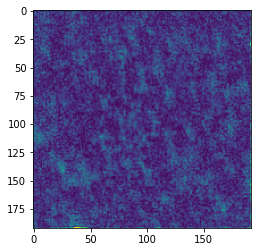

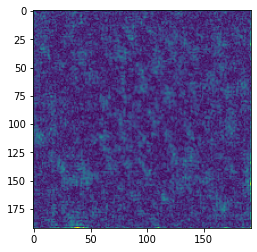

In [8]:
import matplotlib.pyplot as plt
import numpy as np
for img in res:
    plt.figure()
    plt.imshow(abs(img))